# Attention Architecture

In [11]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
import music21

In [13]:
# from fastai.text import *
from enum import Enum
import torch
from fastai.text.models.awd_lstm import *
from fastai.text.models.transformer import *

In [14]:
import numpy as np
import torch.nn as nn

In [15]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [16]:
import sys
sys.path.insert(0, '../../')
from src.fastai_data import *
from src.encode_data import *
from src.serve import *

In [17]:
from src.music_transformer import *

In [18]:
base_path = Path('../../data/midi/v15/')
path = base_path/'piano_duet'

## Single Stream Encoding

In [19]:
config = v15s_config(vocab); config

{'ctx_len': 150,
 'n_layers': 16,
 'n_heads': 8,
 'd_model': 256,
 'd_head': 32,
 'd_inner': 2048,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'pad_idx': 1,
 'bos_idx': 0,
 'sep_idx': 8,
 'transpose_range': (0, 12),
 'rand_transpose': True,
 'rand_bptt': True,
 'note_range': (9, 139),
 'bs': 16,
 'bptt': 256,
 'vocab_size': 274}

In [20]:
config['n_layers'] = 8

In [26]:
learn = music_model_learner(data, config.copy())

True


In [27]:
xb,yb = data.one_batch(cpu=False); xb.shape, yb.shape

(torch.Size([16, 256]), torch.Size([16, 256]))

In [28]:
learn.opt_func

functools.partial(<class 'apex.optimizers.fused_adam.FusedAdam'>, betas=(0.9, 0.99), eps=0.0001)

In [29]:
learn.model.reset()

In [30]:
learn.model(xb)

(tensor([[[-4.1243e-01,  3.1431e-01, -4.0776e-02,  ..., -1.2405e-01,
            9.3776e-02, -1.4018e-01],
          [ 2.9251e-01, -1.9519e-01, -3.0393e-01,  ..., -3.0608e-01,
            2.6302e-01,  7.2774e-01],
          [ 4.3896e-01, -5.8448e-02, -3.2492e-01,  ...,  2.4298e-01,
            4.8975e-01, -5.0008e-01],
          ...,
          [-2.4754e-01, -5.7667e-01, -1.2402e-02,  ...,  1.5109e-02,
            4.8753e-02,  3.9595e-01],
          [-8.0662e-02,  3.4433e-01,  9.2426e-03,  ..., -2.8539e-01,
           -2.0163e-02, -1.3251e-01],
          [-4.5391e-02, -3.1036e-01, -5.0182e-02,  ...,  1.8592e-01,
           -4.5290e-02,  3.8534e-01]],
 
         [[-6.3567e-02,  2.6779e-01,  1.9367e-01,  ..., -2.1840e-01,
            3.0445e-01, -4.8132e-01],
          [ 4.1603e-01, -3.6184e-01, -4.5377e-01,  ..., -4.5596e-01,
            2.1475e-01,  4.8658e-01],
          [ 4.2401e-01, -1.8558e-01, -1.4082e-01,  ...,  4.2298e-01,
            2.7220e-01, -2.3496e-01],
          ...,
    

In [31]:
learn.validate()

[6.0095344, tensor(0.)]

In [32]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.252082,1.181642,0.651611,03:57


In [33]:
csv_path = path/'piano_duet.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

# keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('la-bamba')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results.head()

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1,7,10,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,song_url,section,numpy,ht_mode,midi,title,ht_time_signature,mxl,ht_offset,ht_bpm,ht_key,md5,midi_title,artist,genres,parts,source
193179,https://www.hooktheory.com/theorytab/view/ritc...,chorus,piano_duet/hooktheory/pianoroll/r/ritchie-vale...,1.0,midi_sources/hooktheory/pianoroll/r/ritchie-va...,la-bamba,4.0,NaN,0.0,144.0,C,aeee134e4034e5f98bb630c56d2f7f8c,La Bamba,ritchie-valen,"Pop,Rock",chorus,hooktheory_c


In [34]:
idx = 0
file = base_path/results.numpy.values[idx]; 
# orig = file_path/data_dir/results.mxl.values[idx];
orig = base_path/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v15/midi_sources/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.mid'))

In [35]:
seed_len = 40
song_np = np.load(file)
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(to_single_stream(seed_np))[None]
if torch.cuda.is_available(): xb = xb.cuda()

In [40]:
out_s, seed_s = learn.predict(xb, n_words=200, temperatures=(0.2,0.2), min_p=1/128)
out = to_double_stream(out_s)
seed = to_double_stream(seed_s)

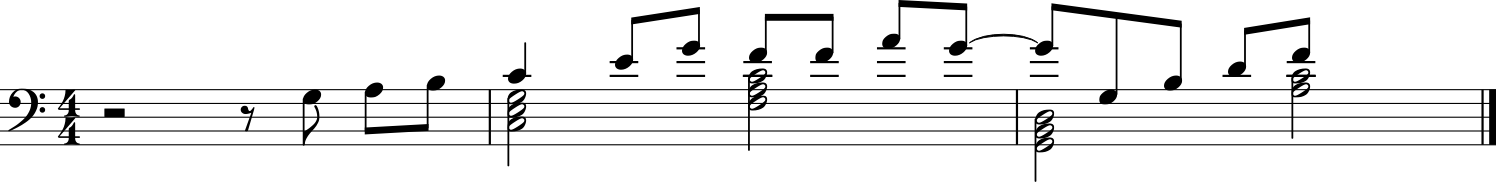

In [41]:
seed_stream = npenc2stream(seed)
seed_stream.show()

In [42]:
out

array([[53,  8],
       [-1,  2],
       [60,  2],
       [-1,  2],
       [62,  2],
       [-1,  2],
       [60,  2],
       [-1,  2],
       [60,  2],
       [-1,  2],
       ...,
       [60,  2],
       [-1,  2],
       [60,  2],
       [-1,  2],
       [60,  2],
       [-1,  2],
       [60,  2],
       [-1,  2],
       [60,  2],
       [-1,  2]])

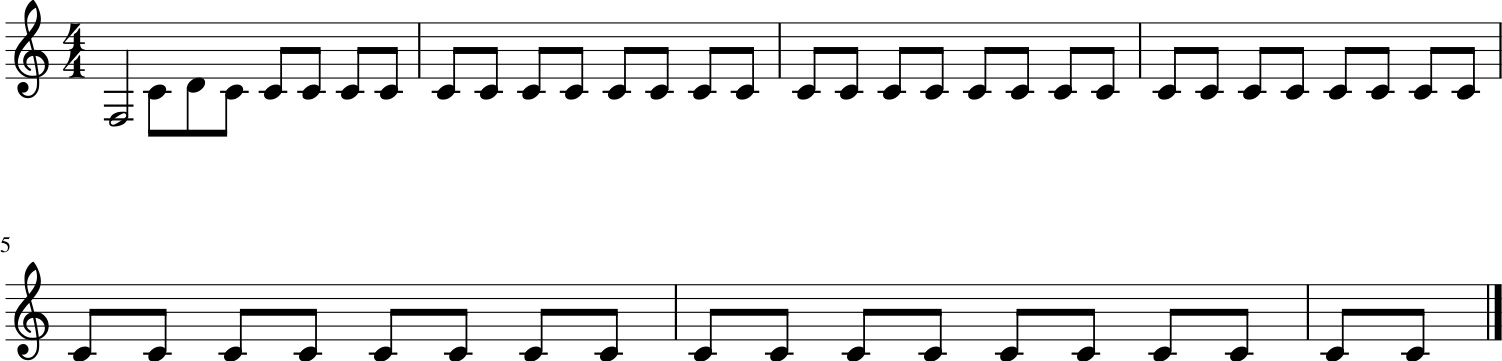

In [43]:
stream = npenc2stream(out)
stream.show()

## Prediction

In [13]:
x,y = data.one_batch(cpu=False)

In [ ]:
out,seed = learn.predict(x, n_words=100)

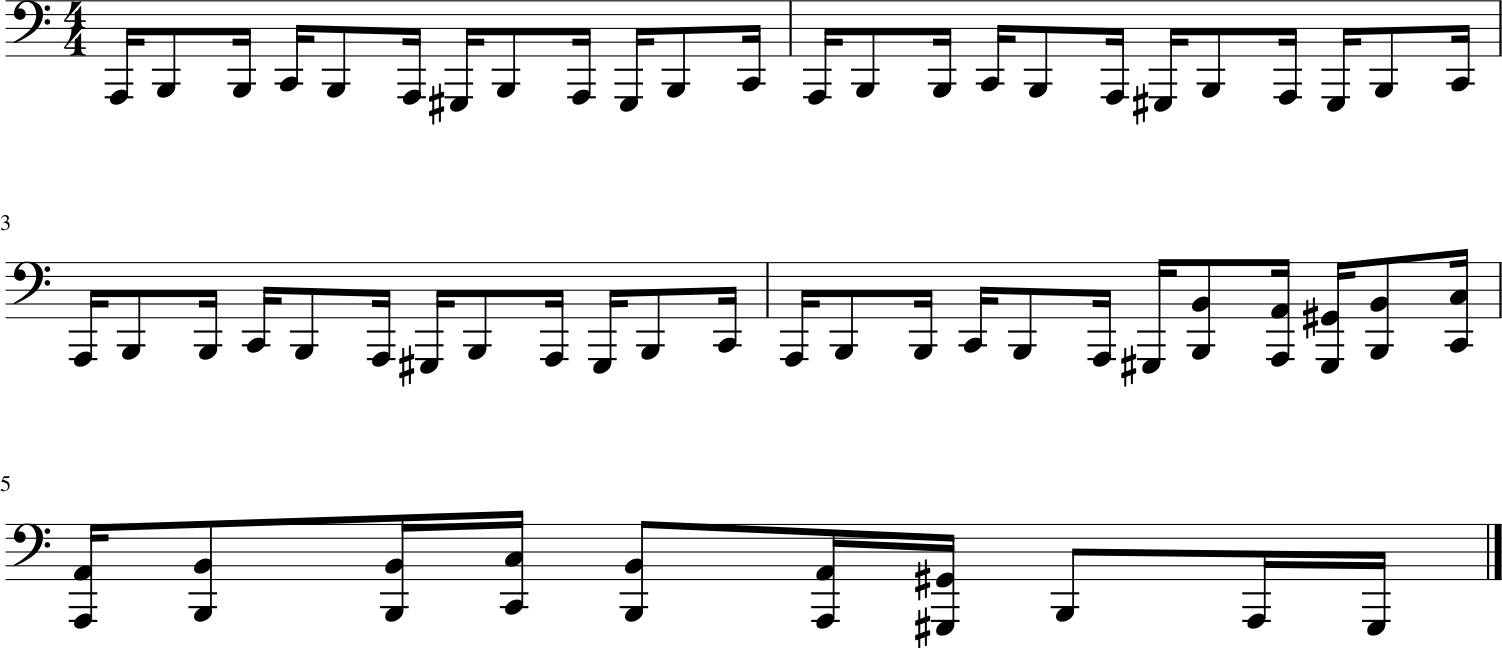

In [20]:
stream = npenc2stream(to_double_stream(seed))
stream.show()

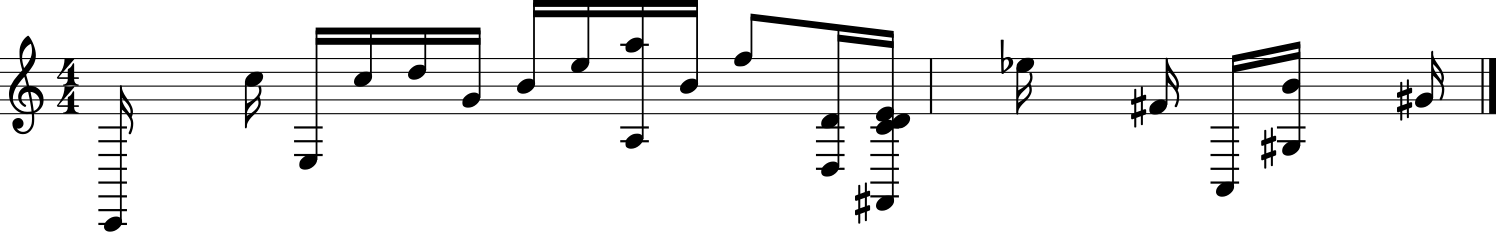

In [21]:
stream = npenc2stream(to_double_stream(out))
stream.show()

### From batch

In [46]:
xb,yb = learn.data.one_batch(cpu=False)

### From song

In [47]:
seed_len = 60
files = get_files(path/'hooktheory', extensions=['.npy'], recurse=True)

In [48]:
# Loading from specific file
keywords = ['third', 'eye']
def contains_keywords(f): return all([k in str(f) for k in keywords])
search = [f for f in files if contains_keywords(f)]; search

[PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/hooktheory/pianoroll/z/zun/satori-maiden---third-eye/verse-and-pre-chorus_key_cmajor.npy'),
 PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/hooktheory/pianoroll/z/zun/satori-maiden---third-eye/chorus_key_cmajor.npy'),
 PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/hooktheory/pianoroll/t/third-eye-blind/jumper/chorus_key_cmajor.npy'),
 PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/hooktheory/pianoroll/t/third-eye-blind/never-let-you-go/verse-and-pre-chorus_key_cmajor.npy'),
 PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/hooktheory/pianoroll/t/third-eye-blind/never-let-you-go/chorus_key_cmajor.npy'),
 PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/hooktheory/pianoroll/t/third-eye-blind/hows-it-going-to-be/intro_key_cmajor.npy'),
 PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/hooktheory/pianoroll/t/third-eye-blind/hows-it-going-to-be/verse_key_cmajor.npy'),
 PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/h

In [49]:
# file = np.random.choice(files)
file = search[-2]
file

PosixPath('data/midi/v8/midi_encode/np/shortdur_2c/hooktheory/pianoroll/t/third-eye-blind/semi-charmed-life/intro_key_cmajor.npy')

In [50]:
#good_one = PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/c/cool-and-new-web-comic/tick---tock/chorus.npy')
# la_bamba = PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/r/ritchie-valen/la-bamba/chorus.npy')
# third_eye = PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/t/third-eye-blind/semi-charmed-life/chorus.npy')

In [51]:
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(seed_np).cuda()[None]

### Predict

In [52]:
out, seed = predict(learn, xb, n_words=340, temperature=.7, min_p=0.01)

### Actual prediction

In [59]:
seq = npenc2seq(np.array(out))
chordarr = seq2chordarr(seq)
stream = chordarr2stream(chordarr)

Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing


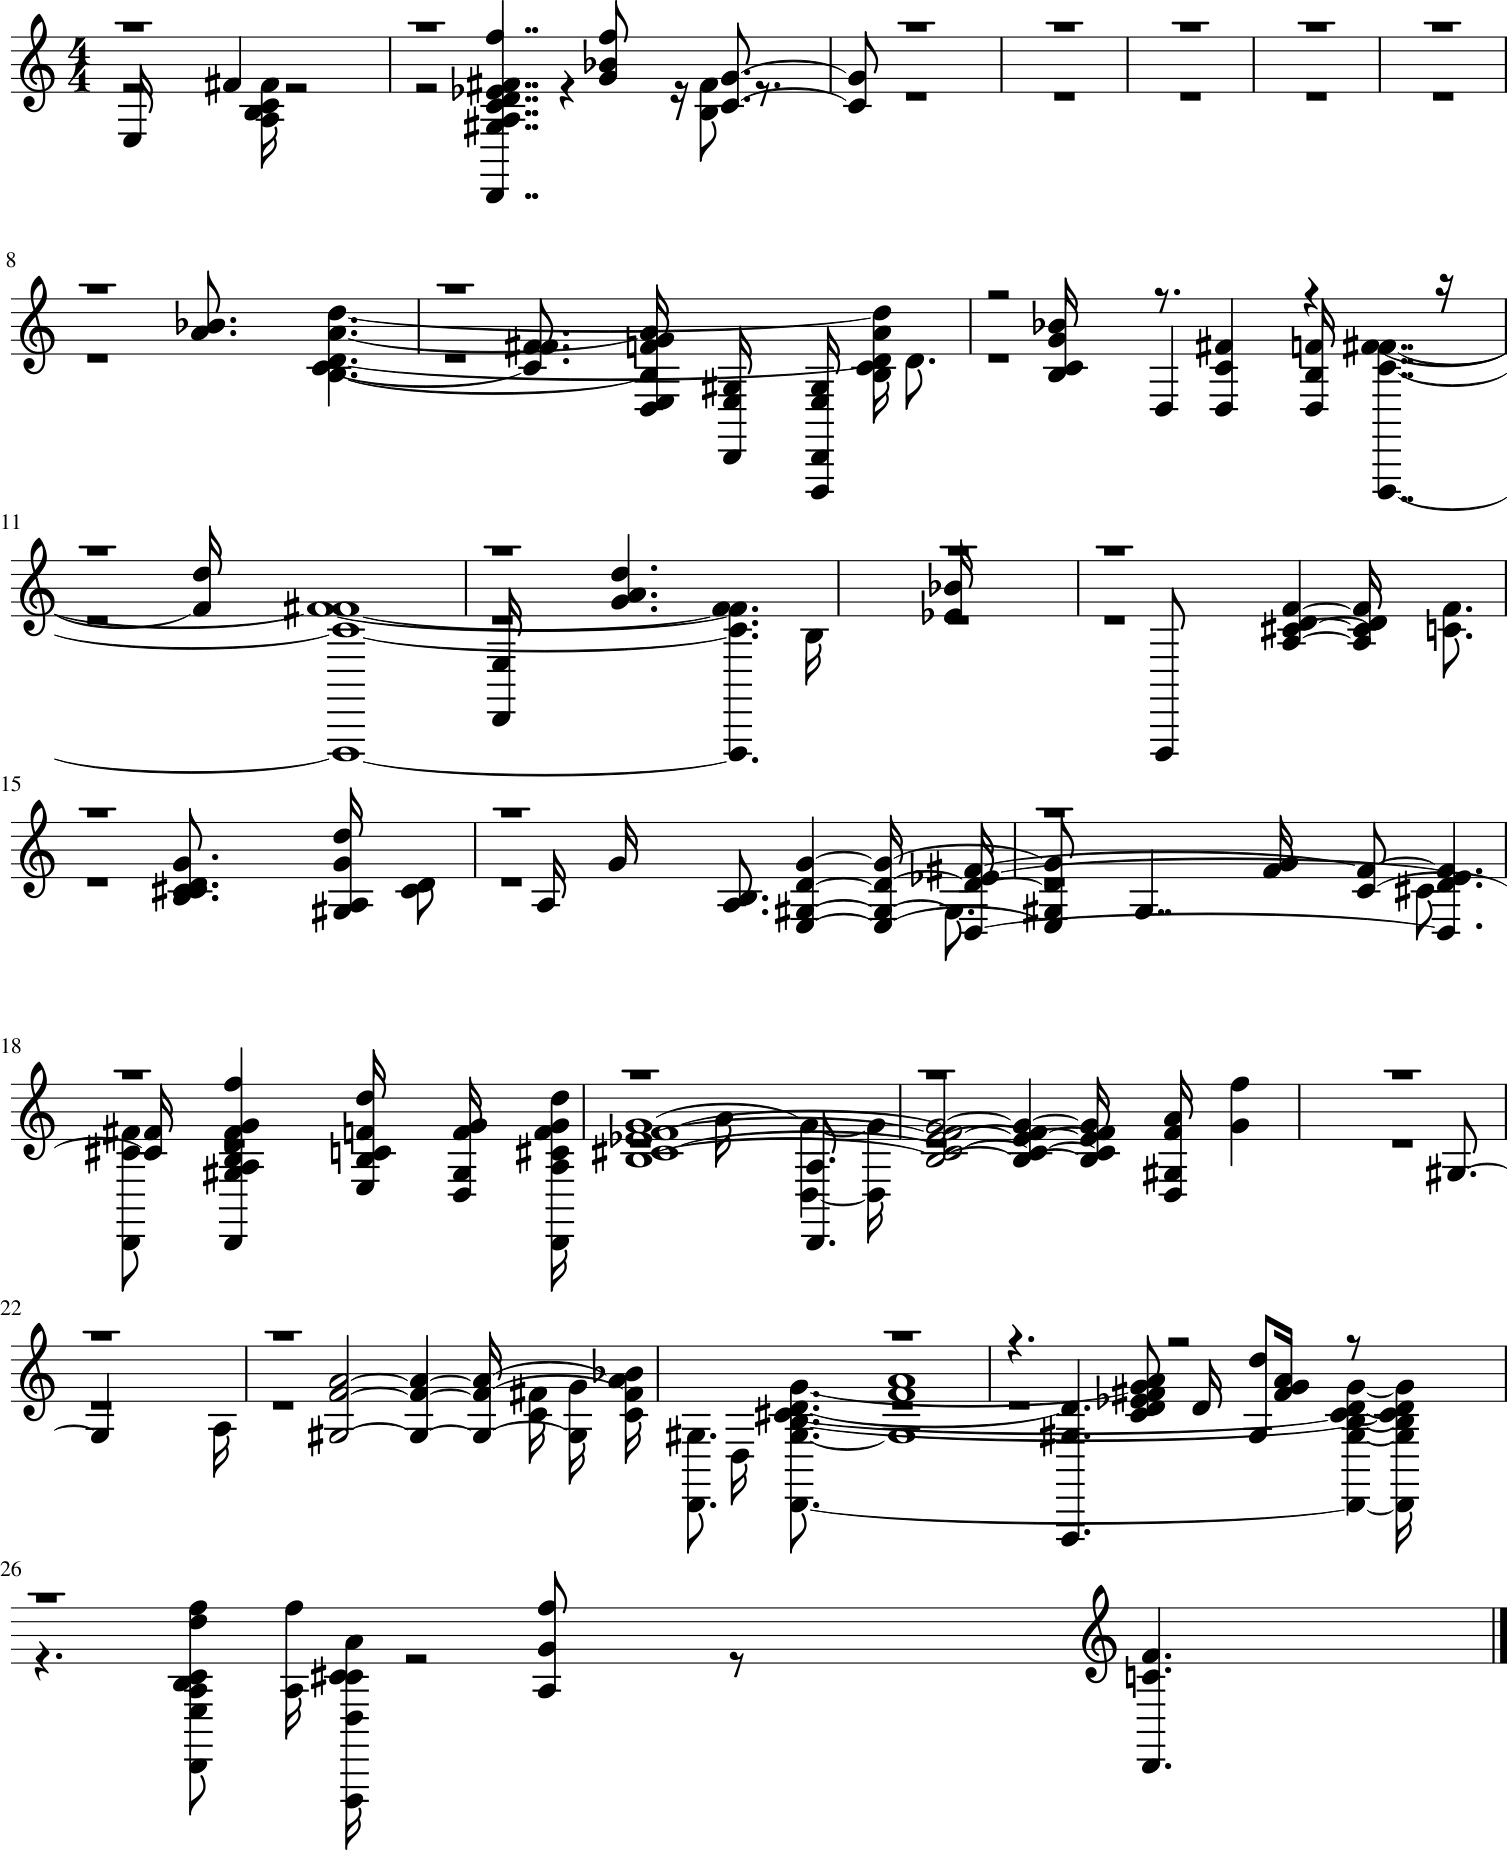

In [60]:
stream.show()

In [61]:
stream.show('midi')

## Seed

In [434]:
seed_song = dec_arr(seed)
seed_stream = seed_song.to_stream()

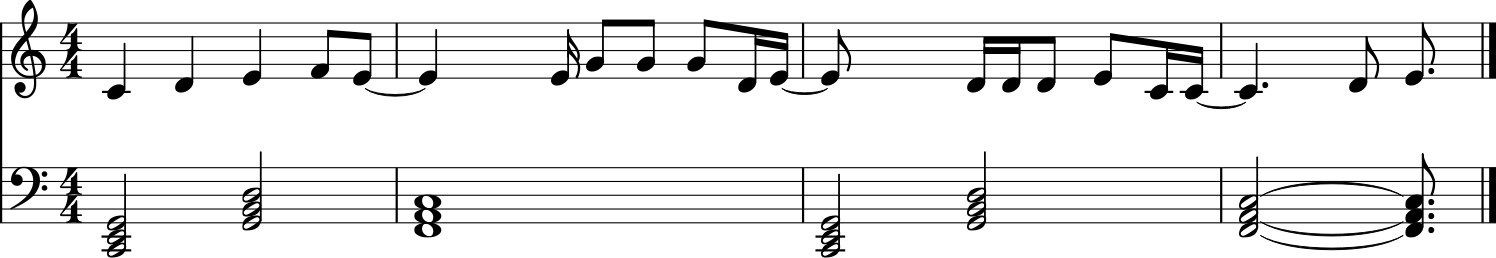

In [435]:
seed_stream.show()

In [436]:
seed_stream.show('midi')